## Neural Network and Convolutional Neural Network Practice

In this notebook, we assemble all following compoments and test the performance.

1. Helper functions
2. Layer functions
3. Multi-layer neural network (initial condition based on layer type)
4. Optimizers
5. Regulation (weight decay, dropout)

In [1]:
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

### Helper functions

For helper functions, we need softmax for final layer output and corss entropy error for evaluating model predicted error.

In [2]:
def softmax(x):
    if x.ndim == 2: # multiple pics
        # direct use x - np.max(x, axis = 1) is not working
        x = x.T # convert x_i from row to column
        x = x - np.max(x, axis = 0) # axis = 0: vertical, find maximum of each pic
        
        y = np.exp(x) / np.sum(np.exp(x), axis = 0)
        return y.T # transpose back to original format

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y_h, y):
    delta = 1e-7
    if y_h.ndim == 1: # labeled ouput
        y = y.reshape(1, y.size)
        y_h = y_h.reshape(1, y_h.size)
        
    batch_size = y_h.shape[0]
    return -np.sum(y * np.log(y_h+delta)) / batch_size

### Layers

The basic structure here is using Affine layer to apply weights on input data, then using either Relu or Sigmoid function to smooth output values. Softmax layer is only used before generating final output.

In [3]:
class Relu():
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        x[self.mask] = 0
        return x
    
    def backward(self, dfdz):
        dfdz[self.mask] = 0
        return dfdz

In [4]:
class Sigmoid():
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out
    
    def backward(self, dfdz):
        return dfdz * (1 - self.out) * self.out

In [5]:
class Affine:
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.x, self.dW, self.db = None, None, None

    def forward(self, x):
        self.x = x
        return np.dot(self.x, self.W) + self.b

    def backward(self, dfdz):
        dx = np.dot(dfdz, self.W.T)
        self.dW = np.dot(self.x.T, dfdz)
        self.db = np.sum(dfdz, axis=0)
        return dx

In [6]:
class SoftmaxWithError():
    def __init__(self):
        self.error, self.y_h, self.y = None, None, None
    
    def forward(self, x, y):
        self.y = y
        self.y_h = softmax(x)
        self.error = cross_entropy_error(self.y_h, self.y)
        return self.error
    
    def backward(self):
        batch_data_size = self.y.shape[0]
        dx = (self.y_h - self.y) / batch_data_size
        return dx

### Multi Layer Design

In [37]:
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_decay_lambda=0, dropout = 0):
        # initiate sizes
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.dropout = dropout
        self.params = {}
        self.layers = OrderedDict()

        # weight initialization
        self.weight_init(activation)
        
        self.layer_init(activation)
        
    def weight_init(self, activation):
        
        total_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        
        for i in range(1, len(total_size_list)): # for n layers, we need n-1 weight matrices 
            if activation == 'relu': # use Kaiming He suggested weight
                scale = np.sqrt( 2 / total_size_list[i-1])
            elif activation == 'sigmoid': # use Xavier suggested weight
                scale = np.sqrt( 1 / total_size_list[i-1])
            
            self.params['W' + str(i)] = scale * np.random.randn(total_size_list[i-1], 
                                                                total_size_list[i])
            self.params['b' + str(i)] = np.zeros(total_size_list[i])
    
    def layer_init(self, activation):
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        
        # 1 to n-1 layer
        for i in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(i)] = Affine(self.params['W' + str(i)],
                                                    self.params['b' + str(i)])
            self.layers['Activation' + str(i)] = activation_layer[activation]()
            
            # add if dropout feature is on (>0)
            if self.dropout > 0:
                self.layers['Dropout' + str(i)] = Dropout(self.dropout)
        
        # n layer is connected to softmax layer
        i = self.hidden_layer_num + 1
        self.layers['Affine' + str(i)] = Affine(self.params['W' + str(i)],
                                                  self.params['b' + str(i)])
        self.last_layer = SoftmaxWithError()

    def predict(self, x, flag = False):
        for key, layer in self.layers.items():
            if 'Dropout' in key:
                x = layer.forward(x, flag)
            else:
                x = layer.forward(x)
        return x

    def error(self, x, y, flag = False):
        y_h = self.predict(x, flag)
        
        # regulation term: here we apply L2 norm 0.5*lambda*|W|^2 as penalty
        weight_decay = 0
        for i in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(i)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y_h, y) + weight_decay

    def accuracy(self, x, y):
        y_h = self.predict(x, flag = False)
        y_h = np.argmax(y_h, axis=1)
        accuracy = np.sum(y_h == y) / float(x.shape[0])
        return accuracy

    def gradient(self, x, y):
        # apply forward propagation to get error
        self.error(x, y, flag = True)

        # then apply backward prapagation to get gradients
        # last layer backward propagate dout
        dout = self.last_layer.backward()

        # call layers in backward order
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        for i in range(1, self.hidden_layer_num+2):
            grads['W' + str(i)] = (
                self.layers['Affine' + str(i)].dW + 
                self.weight_decay_lambda * self.layers['Affine' + str(i)].W)
            
            grads['b' + str(i)] = self.layers['Affine' + str(i)].db

        return grads

### Optimizers


In [8]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

In [9]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr, self.momentum = lr, momentum
        self.vel = None
        
    def update(self, params, grads):
        if self.vel is None:
            self.vel = {}
            for key, val in params.items():                                
                self.vel[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.vel[key] = self.momentum * self.vel[key] - self.lr * grads[key] 
            params[key] += self.vel[key]

In [10]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr, self.h, self.delta = lr, None, 1e-7
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + self.delta)

In [11]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr, self.beta1, self.beta2 = lr, beta1, beta2
        self.iter, self.m, self.v = 0, None, None
        self.delta = 1e-7
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key], self.v[key] = np.zeros_like(val), np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + self.delta)

In [12]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr, self.decay_rate, self.h = lr, decay_rate, None
        self.delta = 1e-7
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + self.delta)

### Regulation

Dropout feature is implemented below. Weight decay is implemented inside the multi layer class.

ref: https://arxiv.org/abs/1207.0580

In [13]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio, self.mask = dropout_ratio, None

    def forward(self, x, flag=True):
        if flag:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dfdz):
        return dfdz * self.mask

### Test optimizer performance 

In [29]:
import os
from mnist import MNIST
mnidata = MNIST(os.getcwd()+'/Data')
train_img, train_lab = mnidata.load_training()
test_img, test_lab = mnidata.load_testing()

# convert python list to to numpy array
train_data, train_label = np.array(train_img), np.array(train_lab)
test_data, test_label = np.array(test_img), np.array(test_lab)

# normalize image
train_data, test_data = train_data.astype(np.float32), test_data.astype(np.float32)
train_data /= 255.0
test_data /= 255.0

# convert label to one hot encoding
def one_hot_encoding(labels, num_of_classes):
    res = np.eye(num_of_classes)[np.array(labels).reshape(-1)]
    return res.reshape(list(labels.shape)+[num_of_classes])

train_label, test_label = one_hot_encoding(train_label, 10), one_hot_encoding(test_label, 10)

In [30]:
# initialize optimizers for comparsion
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSprop'] = RMSprop()

In [31]:
# initiate networks
networks = {}
train_error = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, 
        hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_error[key] = [] 

In [32]:
# set up modeling parameters
iteration_number = 6000
train_data_size = train_data.shape[0]
batch_data_size = 100
iter_per_epoch = train_data_size/batch_data_size

In [18]:
for i in range(iteration_number):
    batch_mask = np.random.choice(train_data_size, batch_data_size)
    traing_data_batch = train_data[batch_mask]
    train_label_batch = train_label[batch_mask]
    
    for key in optimizers.keys():
        # compute gradients
        grads = networks[key].gradient(traing_data_batch, train_label_batch)
        
        # update weights
        optimizers[key].update(networks[key].params, grads)
    
    if i % iter_per_epoch == 0:
        print( "---- " + str(i//iter_per_epoch)[:-2] +" epoch" "----" )
        for key in optimizers.keys():
            # record error
            train_error[key].append(
                networks[key].error(traing_data_batch, train_label_batch)
            )
            print(key + ":" + str(train_error[key][-1]))

---- 0 epoch----
SGD:2.4126593278980732
Momentum:2.4824119407976144
AdaGrad:1.9255096172700095
Adam:2.1097644713320585
RMSprop:14.02274320333374
---- 1 epoch----
SGD:0.35900973481252035
Momentum:0.12733030320239777
AdaGrad:0.04931317149740815
Adam:0.10300182489527422
RMSprop:0.05512907709919905
---- 2 epoch----
SGD:0.29849170932570224
Momentum:0.09475089162151422
AdaGrad:0.08591189215692391
Adam:0.09161760570315777
RMSprop:0.1513937225110471
---- 3 epoch----
SGD:0.18084758229264858
Momentum:0.12511166664519158
AdaGrad:0.07127331966294932
Adam:0.12129389353427297
RMSprop:0.08153721630972262
---- 4 epoch----
SGD:0.20335956003001493
Momentum:0.051901399409857565
AdaGrad:0.020958849463065414
Adam:0.043404525098477295
RMSprop:0.23685304447752123
---- 5 epoch----
SGD:0.18800263594740352
Momentum:0.07849232664455949
AdaGrad:0.02042725103997451
Adam:0.01807635512157989
RMSprop:0.062109312018283624
---- 6 epoch----
SGD:0.10216269892798724
Momentum:0.0303401015945391
AdaGrad:0.01817090867864693


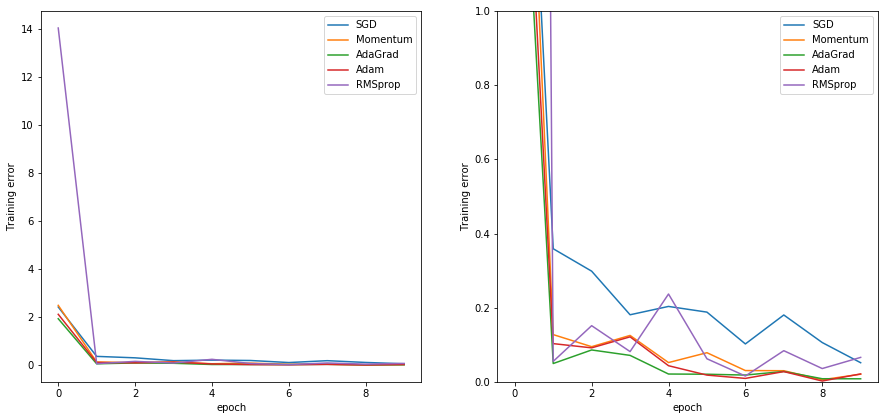

In [19]:
from matplotlib import pyplot as plt

_ = plt.figure(figsize = (15,15))
_ = plt.subplot(2,2,1)

for key in optimizers.keys():
    _ = plt.plot(train_error[key], label=key)
_ = plt.xlabel("epoch")
_ = plt.ylabel("Training error")
_ = plt.legend()

_ = plt.subplot(2,2,2)

for key in optimizers.keys():
    _ = plt.plot(train_error[key], label=key)
_ = plt.xlabel("epoch")
_ = plt.ylabel("Training error")
_ = plt.ylim(0, 1)
_ = plt.legend()

### Test weight decay and dropout features for controlling overfitting

Reduce the data sample size and add more layers to generate overfitting situation, and use weight decay and dropout to reduce the overfitting effects.

In [54]:
# reduce training data size
of_train_data, of_train_label = train_data[:300], train_label[:300]

# initialize 7 layer network with weight decay rate 0.1
of_network = MultiLayerNet(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100],
    output_size=10, 
    weight_decay_lambda = 0)

# optimizer
opt_sgd = SGD()

# logs
train_error_list = []
train_acc_list = []
test_acc_list = []

In [57]:
# set up modeling parameters
iteration_number = 100
train_data_size = of_train_data.shape[0]
batch_data_size = 100
iter_per_epoch = train_data_size/batch_data_size

In [58]:
for i in range(iteration_number):
    batch_mask = np.random.choice(train_data_size, batch_data_size)
    traing_data_batch = of_train_data[batch_mask]
    train_label_batch = of_train_label[batch_mask]
    
    # compute gradients
    grads = of_network.gradient(traing_data_batch, train_label_batch)
        
    # update weights
    opt_sgd.update(of_network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = of_network.accuracy(train_data, train_label)
        test_acc = of_network.accuracy(test_data, test_label)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("---- " + str(i//iter_per_epoch)[:-2] +" epoch" "----" )
        print("Training set accuracy: " + str(train_acc))
        print("Testing set accuracy: " + str(test_acc))

---- 0 epoch----
Training set accuracy: 0.2744333333333333
Testing set accuracy: 0.2647
---- 1 epoch----
Training set accuracy: 0.28736666666666666
Testing set accuracy: 0.2784
---- 2 epoch----
Training set accuracy: 0.31501666666666667
Testing set accuracy: 0.3045
---- 3 epoch----
Training set accuracy: 0.32765
Testing set accuracy: 0.3174
---- 4 epoch----
Training set accuracy: 0.33821666666666667
Testing set accuracy: 0.3291
---- 5 epoch----
Training set accuracy: 0.3466
Testing set accuracy: 0.3388
---- 6 epoch----
Training set accuracy: 0.3626666666666667
Testing set accuracy: 0.3565
---- 7 epoch----
Training set accuracy: 0.37466666666666665
Testing set accuracy: 0.3687
---- 8 epoch----
Training set accuracy: 0.3784
Testing set accuracy: 0.3744
---- 9 epoch----
Training set accuracy: 0.39025
Testing set accuracy: 0.3879
---- 10 epoch----
Training set accuracy: 0.4019666666666667
Testing set accuracy: 0.3982
---- 11 epoch----
Training set accuracy: 0.4106
Testing set accuracy: 0.4

In [63]:
# initialize 7 layer network with weight decay rate 0.1
of_network_weight_decay = MultiLayerNet(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100],
    output_size=10, 
    weight_decay_lambda = 0.1)

# optimizer
opt_sgd_wd = SGD()

# logs
train_error_list_wd = []
train_acc_list_wd = []
test_acc_list_wd = []

In [64]:
for i in range(iteration_number):
    batch_mask = np.random.choice(train_data_size, batch_data_size)
    traing_data_batch = of_train_data[batch_mask]
    train_label_batch = of_train_label[batch_mask]
    
    # compute gradients
    grads = of_network_weight_decay.gradient(traing_data_batch, train_label_batch)
        
    # update weights
    opt_sgd_wd.update(of_network_weight_decay.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = of_network_weight_decay.accuracy(train_data, train_label)
        test_acc = of_network_weight_decay.accuracy(test_data, test_label)
        train_acc_list_wd.append(train_acc)
        test_acc_list_wd.append(test_acc)
        print("---- " + str(i//iter_per_epoch)[:-2] +" epoch" "----" )
        print("Training set accuracy: " + str(train_acc))
        print("Testing set accuracy: " + str(test_acc))

---- 0 epoch----
Training set accuracy: 0.1264
Testing set accuracy: 0.1318
---- 1 epoch----
Training set accuracy: 0.13916666666666666
Testing set accuracy: 0.1442
---- 2 epoch----
Training set accuracy: 0.16001666666666667
Testing set accuracy: 0.1613
---- 3 epoch----
Training set accuracy: 0.17728333333333332
Testing set accuracy: 0.1767
---- 4 epoch----
Training set accuracy: 0.19531666666666667
Testing set accuracy: 0.1942
---- 5 epoch----
Training set accuracy: 0.2164
Testing set accuracy: 0.2159
---- 6 epoch----
Training set accuracy: 0.24048333333333333
Testing set accuracy: 0.2373
---- 7 epoch----
Training set accuracy: 0.25511666666666666
Testing set accuracy: 0.2539
---- 8 epoch----
Training set accuracy: 0.27295
Testing set accuracy: 0.2693
---- 9 epoch----
Training set accuracy: 0.29225
Testing set accuracy: 0.2879
---- 10 epoch----
Training set accuracy: 0.3055333333333333
Testing set accuracy: 0.304
---- 11 epoch----
Training set accuracy: 0.30945
Testing set accuracy: 0

In [66]:
# initialize 7 layer network with weight decay rate 0.1
of_network_dropout = MultiLayerNet(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100],
    output_size=10, 
    dropout=0.2)

# optimizer
opt_sgd_drop = SGD()

# error logs
train_error_list_drop = []
train_acc_list_drop = []
test_acc_list_drop = []

In [67]:
for i in range(iteration_number):
    batch_mask = np.random.choice(train_data_size, batch_data_size)
    traing_data_batch = of_train_data[batch_mask]
    train_label_batch = of_train_label[batch_mask]
    
    # compute gradients
    grads = of_network_dropout.gradient(traing_data_batch, train_label_batch)
        
    # update weights
    opt_sgd_drop.update(of_network_dropout.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = of_network_dropout.accuracy(train_data, train_label)
        test_acc = of_network_dropout.accuracy(test_data, test_label)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("---- " + str(i//iter_per_epoch)[:-2] +" epoch" "----" )
        print("Training set accuracy: " + str(train_acc))
        print("Testing set accuracy: " + str(test_acc))

---- 0 epoch----
Training set accuracy: 0.12575
Testing set accuracy: 0.1292
---- 1 epoch----
Training set accuracy: 0.12471666666666667
Testing set accuracy: 0.1287
---- 2 epoch----
Training set accuracy: 0.12548333333333334
Testing set accuracy: 0.1292
---- 3 epoch----
Training set accuracy: 0.12606666666666666
Testing set accuracy: 0.1297
---- 4 epoch----
Training set accuracy: 0.12425
Testing set accuracy: 0.1273
---- 5 epoch----
Training set accuracy: 0.12493333333333333
Testing set accuracy: 0.1276
---- 6 epoch----
Training set accuracy: 0.12446666666666667
Testing set accuracy: 0.1275
---- 7 epoch----
Training set accuracy: 0.1243
Testing set accuracy: 0.1264
---- 8 epoch----
Training set accuracy: 0.12196666666666667
Testing set accuracy: 0.1241
---- 9 epoch----
Training set accuracy: 0.12193333333333334
Testing set accuracy: 0.1255
---- 10 epoch----
Training set accuracy: 0.1225
Testing set accuracy: 0.1259
---- 11 epoch----
Training set accuracy: 0.12311666666666667
Testing s